<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Process-data" data-toc-modified-id="Process-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process data</a></span><ul class="toc-item"><li><span><a href="#Spatial-average" data-toc-modified-id="Spatial-average-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Spatial average</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualize</a></span></li></ul></div>

# Import libraries

In [2]:
import xarray as xr
import xarray.ufuncs as xrf
from averaging import xarray_average
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xclim as xc

In [3]:
%reload_ext watermark
%watermark --iversions -v -m

xclim   0.15.2
numpy   1.17.3
xarray  0.15.1
seaborn 0.9.0
pandas  1.0.5
CPython 3.6.9
IPython 7.1.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-112-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Load data

In [4]:
inpath = '/mnt/4data/CMAM/0A.daily/'
ds = xr.open_dataset(f'{inpath}accelogw/accelogw_daily_CMAM_CMAM30-SD_r1i1p1_19790101-20101231_70hPa.nc')
ds

<xarray.Dataset>
Dimensions:   (lat: 48, lon: 96, time: 11688)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2010-12-31
    plev      float64 ...
  * lat       (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon       (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Data variables:
    accelogw  (time, lat, lon) float64 ...

# Process data

In [5]:
time_mask = (ds.time.dt.month == 12) | (ds.time.dt.month == 1) | (ds.time.dt.month == 2)
ds_sel = ds['accelogw'].sel(time = time_mask)

sel_dict_ea = dict(lon =slice(110,145), lat=slice(30,48)) 
sel_dict_hi = dict(lon =slice(70,102.5), lat=slice(20,40)) 
sel_dict_wa = dict(lon =slice(-125+360,-102.5+360), lat=slice(27.5,52)) 

sel_dict_ls = {'Himalayas': sel_dict_hi, \
               'West America': sel_dict_wa, \
               'East Asia': sel_dict_ea}
weights = xrf.cos(xrf.deg2rad(ds_sel.lat))

In [6]:
ts_ls = []
g_ls = []
for hs_name in sel_dict_ls.keys():
    print(hs_name)
    sel_dict = sel_dict_ls[hs_name]
    ds_sel_hs = ds_sel.sel(**sel_dict)
    #ds_sel_hs = xarray_average(ds_sel_hs, dim = ['lat', 'lon'], weights = weights)#.load()
    #ds_sel_hs.name = 'accelogw'
    ts = ds_sel_hs.dropna('time').to_series().reset_index()
    #sys.exit()
    g_ls += [hs_name]*ts.shape[0]    
    ts_ls.append(ts)

df = pd.concat(ts_ls)
df['g'] = g_ls
df['accelogw'] = df['accelogw']*24*3600
df.head()

Himalayas
West America
East Asia


,time,lat,lon,accelogw,g
0,1979-01-01,20.411238,71.25,5.009432e-09,Himalayas
1,1979-01-01,20.411238,75.00,5.009432e-09,Himalayas
2,1979-01-01,20.411238,78.75,5.009432e-09,Himalayas
3,1979-01-01,20.411238,82.50,-2.866767e-01,Himalayas
4,1979-01-01,20.411238,86.25,-5.888247e-03,Himalayas


## Spatial average

In [7]:
ts_ls = []
g_ls = []
for hs_name in sel_dict_ls.keys():
    sel_dict = sel_dict_ls[hs_name]
    ds_sel_hs = ds_sel.sel(**sel_dict)
    ds_sel_hs = xarray_average(ds_sel_hs, dim = ['lat', 'lon'], weights = weights)#.load()
    ds_sel_hs.name = 'accelogw'
    ts = ds_sel_hs.dropna('time').to_series().reset_index()
    g_ls += [hs_name]*ts.shape[0]    
    ts_ls.append(ts)

df2 = pd.concat(ts_ls)
df2['g'] = g_ls
df2['accelogw'] = df2['accelogw']*24*3600
df2.head()

,time,accelogw,g
0,1979-01-01,-1.062378,Himalayas
1,1979-01-02,-1.030545,Himalayas
2,1979-01-03,-1.483128,Himalayas
3,1979-01-04,-1.021822,Himalayas
4,1979-01-05,-1.749732,Himalayas


# Visualize

Text(1.3039843749999989, 0.5, 'Occurrence density')

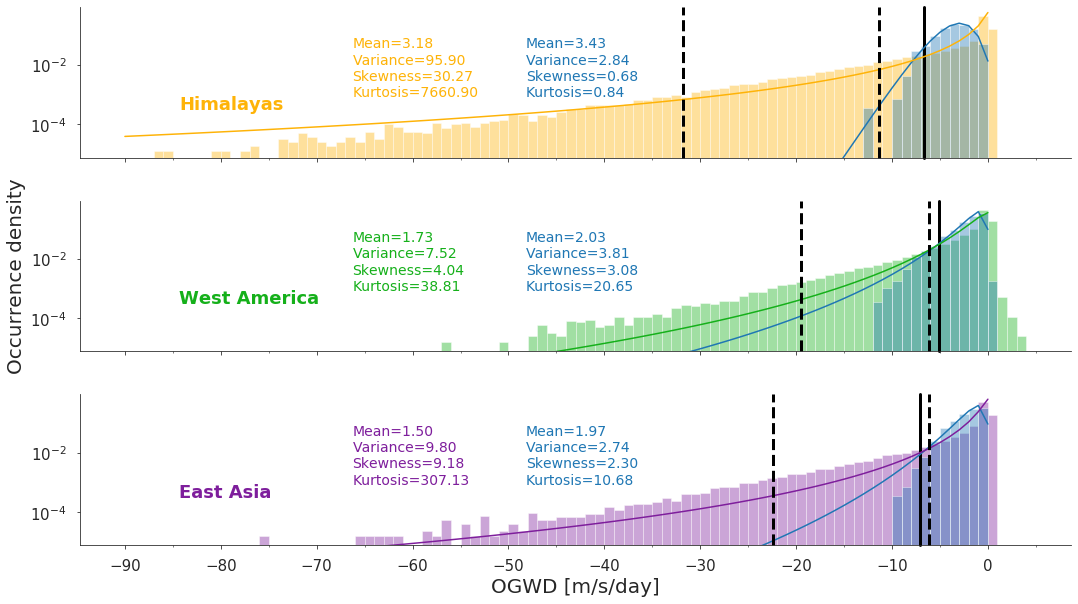

In [10]:
plt.rcParams.update({'font.size': 18})
# Initialize the FacetGrid object
bins = np.arange(-90,5)
bins_fit = np.arange(-90,1)
#bins = np.arange(-90,10,5)
xticks = np.arange(-90,10,10)
min_xticks = np.arange(-85,5,10)
nh = len(sel_dict_ls)
pal = sns.cubehelix_palette(nh, light=.7) # rot=-.25,
colors = ["amber", "green", "purple"] #  , "greyish",
pal = sns.xkcd_palette(colors)
sns.set_style("ticks", {"xtick.major.size": 10, "ytick.major.size": 10})
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, palette=pal)
g.map(sns.distplot, "accelogw", norm_hist = True, kde=False, rug=False, bins = bins)

g.axes[0][0].axvline(x=-6.66, lw=3, clip_on=False, color = 'k')#pal[0])
g.axes[1][0].axvline(x=-5.07, lw=3, clip_on=False, color = 'k')#pal[1])
g.axes[2][0].axvline(x=-7.13, lw=3, clip_on=False, color = 'k')#pal[2])

quantiles = df.groupby('g').quantile([0.01,0.1])['accelogw']
dist_name = 'exponweib'
#dist_name = 'weibull_min' #
dist_name = 'lognorm' #  # 'gamma'
dist = xc.indices.generic.get_dist(dist_name)

m_const = -1
for i, hs_name in enumerate(sel_dict_ls.keys()):
    ax = g.axes[i][0]
    
    arr = df2["accelogw"][df2['g'] == hs_name]
    arr.index.name = 'time'
    
    
    arr = arr.to_xarray()
    arr = arr.where(arr < 1).dropna('time')
    sns.distplot(arr, norm_hist = True, kde=False, rug=False, \
             bins = bins, ax = ax)
    ind = xc.indices.generic.fit(arr*m_const, dist = dist_name).compute()
    
    
    mean, var, skew, kurt = dist.stats(*ind.values, moments='mvsk')
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (np.log(ind.loc['loc']), ),
        r'$\sigma=%.2f$' % (ind.loc['s'], )))
    
    textstr = '\n'.join((
        'Mean=%.2f' % (mean, ),
        'Variance=%.2f' % (var, ),
        'Skewness=%.2f' % (skew, ),
        'Kurtosis=%.2f' % (kurt, )))
    ax.text(0.45, 0.8, textstr, fontsize=14, verticalalignment='top', \
            color = 'C0', transform=ax.transAxes)  
    

    
    ax.plot(bins_fit,dist.pdf(bins_fit*m_const, *ind.values), color = 'C0')
    
    arr = df["accelogw"][df['g'] == hs_name]
    arr.index.name = 'time'
    arr = arr.to_xarray()
    arr = arr.where(arr < 1).dropna('time')

    ind = xc.indices.generic.fit(arr*-1, dist = dist_name).compute()
    dist = xc.indices.generic.get_dist(dist_name)
    ax.plot(bins_fit, dist.pdf(bins_fit*-1, *ind.values), color = pal[i])
    
        
    mean, var, skew, kurt = dist.stats(*ind.values, moments='mvsk')
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (np.log(ind.loc['loc']), ),
        r'$\sigma=%.2f$' % (ind.loc['s'], )))
    
    textstr = '\n'.join((
        'Mean=%.2f' % (mean, ),
        'Variance=%.2f' % (var, ),
        'Skewness=%.2f' % (skew, ),
        'Kurtosis=%.2f' % (kurt, )))
    ax.text(0.275, 0.8, textstr, fontsize=14, verticalalignment='top', \
            color = pal[i], transform=ax.transAxes)  
    

    ax.axvline(x=quantiles[hs_name][0.01], lw=3, clip_on=False, \
                         color = 'k', linestyle = 'dashed')
    ax.axvline(x=quantiles[hs_name][0.1], lw=3, clip_on=False, \
                         color = 'k', linestyle = 'dashed')
    
    ax.tick_params(axis="y",direction="out", pad=10, labelsize = 15)
    ax.tick_params(axis="x",direction="out", pad=10, labelsize = 15)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax.set_ylim(0,0.9)
    ax.set_yscale('log')
    
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.1, .35, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "accelogw")
g.set(xticks=xticks)
# Set the subplots to overlap
#g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
#g.set(yscale="log")
g.axes[nh-1][0].set_xlabel('OGWD [m/s/day]', fontsize = 20)
g.axes[nh-2][0].set_ylabel('Occurrence density', fontsize = 20)

#plt.savefig(f'OGWD_distribution_hotspots_DJFonly_wfits_{dist_name}.pdf', bbox_inches='tight') 